In [1]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from DCmatch import Match

(array([4830.,    0., 3535.,    0., 1262.,    0.,  293.,    0.,   72.,
           8.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

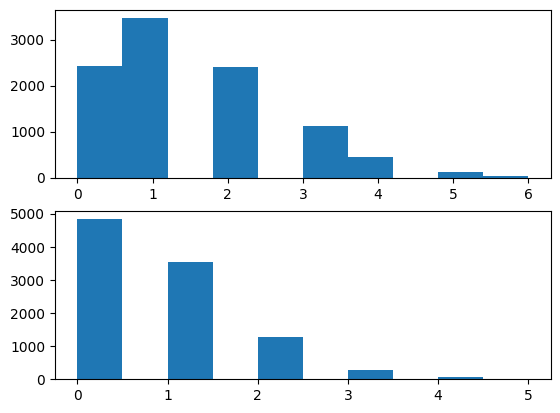

In [2]:
# EXAMPLE: Average Prem team vs average Championship team
premVSchamp = Match(1.38, 0.68, 1.07, 0.86, 1.2, 0.5, 7)
homeGoals = []
awayGoals = []

for i in range(10000):
    result = premVSchamp.simulateResult()
    homeGoals.append(result[0])
    awayGoals.append(result[1])

fig, ax = plt.subplots(2, 1)
ax[0].hist(homeGoals)
ax[1].hist(awayGoals)

In [3]:
premVSchamp.getOutcomeProbs()

[0.5970598831158433, 0.15142902890080862, 0.2515110879833481]

In [11]:
teams = [i for i in range(10)]
attackStrengths = [0.2*(i+1) for i in range(10)]
defenceStrengths = [0.2*(10-i) for i in range(10)]

homeAdv = 1.2
rho = 0.5
maxGoals = 7

results = pd.DataFrame(columns=["HomeTeam", "AwayTeam", "HomeGoals", "AwayGoals"])

# simulate 100 games between the teams at random
for i in range(1000):
    currentTeams = random.sample(teams, 2)
    homeTeam = currentTeams[0]
    awayTeam = currentTeams[1]
    # simulate match
    currentMatch = Match(attackStrengths[homeTeam], defenceStrengths[homeTeam], attackStrengths[awayTeam], defenceStrengths[awayTeam],
                        homeAdv, rho, maxGoals)
    scoreline = currentMatch.simulateResult()
    # add match to match DataFrame
    results.loc[i] = [homeTeam, awayTeam, scoreline[0], scoreline[1]]
    # use Dixon Coles to estimate parameters

In [5]:
results.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,7,2,4,0
1,1,6,1,3
2,5,7,3,3
3,9,5,1,0
4,8,4,6,0


In [6]:
from scipy.optimize import minimize

In [7]:
def logLikelihood(parameters, data):
    numTeams = int((len(parameters) - 2) // 2)
    
    attackStrengths = np.array(parameters[0:numTeams])
    defenceStrengths = np.array(parameters[numTeams:numTeams*2])
    
    homeAdv = parameters[-2]
    rho = parameters[-1]

    attackStrengths = attackStrengths - np.mean(attackStrengths)
    defenceStrengths = defenceStrengths - np.mean(defenceStrengths)

    ll = 0
    epsilon = 1e-7


    for _, row in data.iterrows():
        i = int(row["HomeTeam"])
        j = int(row["AwayTeam"])
        x = int(row["HomeGoals"])
        y = int(row["AwayGoals"])

        lamd = attackStrengths[i] * defenceStrengths[j] * homeAdv
        mu = attackStrengths[j] * defenceStrengths[i]
        lamd = max(lamd, epsilon)
        mu = max(mu, epsilon)

        ll += np.log(Match.tauFunc(lamd, mu, rho, x, y) + epsilon) - lamd + x*np.log(max(lamd, epsilon)) - mu + y*np.log(max(mu, epsilon))
    
    return -ll


In [8]:
rng = np.random.default_rng(123)
init_att = rng.uniform(0.3, 1.2, size=10)
init_def = rng.uniform(0.3, 1.2, size=10)
init_home = 1.1
init_rho = 0.0

init = np.concatenate([init_att, init_def, [init_home, init_rho]])

bounds = [(1e-6, None)] * (2*10) + [(1e-6, None), (-0.99, 0.99)]

result = minimize(
    logLikelihood,
    init,
    args=(results,),
    bounds=bounds,
    method='Nelder-Mead',  # or 'Powell'
    options={'maxiter': 20000, 'disp': True}
)

/var/folders/c8/mqhljcz12rld881pkd18bzxc0000gn/T/ipykernel_80237/2565785046.py:11: RuntimeWarning: Maximum number of iterations has been exceeded.
  result = minimize(


In [9]:
np.set_printoptions(suppress=True)
result.x

array([ 8.19573078,  4.42742031,  3.9379297 ,  1.64489539,  2.19807244,
       11.54113944, 11.56648625,  0.546429  , 12.94314354, 13.9755432 ,
        0.02223987,  0.00000379,  0.83699786,  0.03920066,  0.73754565,
        0.66027282,  0.64762057,  0.28389167,  0.51836931,  0.47061412,
        1.20900393, -0.05228065])

In [10]:
result.message

'Maximum number of iterations has been exceeded.'